# Note
1. The kin should always be the same and not changing with the Ec
2. When defining a fucntion that you are going to use a lot of times, only include the most essential part in the function.
3. For scientific calculation, you need to have a mathematical theory for every equation / relation you use. Especially on the unit conversions with fft.
4. When showing your results to others, always have all the related website and notebook ready for demonstration to prove yourself. For example, in this case, you need to have the x-server website open to show that you are using the correct chi value for this exact photon energy.
5. Derive the theory carefully. Remove redundant factors in your calculation.
6. I have told you sometime ago that with parameters from X-server, you do not need the polarization factor P because it is already included in their parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Constant
hbar = 0.0006582119514  # This is the reduced planck constant in keV/fs
c = 299792458. * 1e-9  # The speed of light in um / fs

Diamond004 = {"chi0": complex(-0.15120e-4, 0.13215E-07),
              "chih_sigma": complex(0.37815E-05, -0.12054E-07),
              "chihbar_sigma": complex(0.37815E-05, -0.12054E-07),
              "chih_pi": complex(0.45275E-09, -0.35732E-09),
              "chihbar_pi": complex(0.45275E-09, -0.35732E-09),
              "spacing": 0.89170e-4,  # [A]
              "bragg_angle": 45.003  # [deg]          
              }

In [3]:
def kev_to_wavevec_length(energy):
    return energy / hbar / c

def get_k_mesh_1d(number, energy_range):
    """
    Get a (n,3) numpy array as the wave vector array.

    Here, the output[:,2] contains non-zero values.
    I.e. I assume that the propagation direction is along z direction.

    :param number:
    :param energy_range:
    :return:
    """
    # Get the corresponding energy mesh
    energy_grid_z = np.linspace(start=- energy_range,
                                stop=+ energy_range,
                                num=number)

    # Get the k grid
    kz_grid = np.ascontiguousarray(kev_to_wavevec_length(energy=energy_grid_z))

    # Get a wave vector array
    k_grid = np.zeros((kz_grid.shape[0], 3), dtype=np.float64)
    k_grid[:, 2] = kz_grid[:]

    # Get the spatial mesh along z rotation_axis
    dkz = kev_to_wavevec_length(energy=energy_grid_z[1] - energy_grid_z[0])
    z_range = np.pi * 2 / dkz

    z_idx = np.linspace(start=-z_range / 2., stop=z_range / 2., num=number)
    z_idx_tick = ["{:.2f}".format(x) for x in z_idx]

    # Assemble the indexes and labels
    axis_info = {"spatial_range": z_range,
                 "spatial_grid": z_idx,
                 "spatial_grid_tick": z_idx_tick,
                 "dkz": dkz,
                 "energy_grid": energy_grid_z,
                 "time_grid": np.divide(z_idx, c),
                 "time_grid_tick": ["{:.2f}".format(x) for x in np.divide(z_idx, c)],
                 }

    return k_grid, axis_info


def get_laue_transmission(kin_grid, normal_grid, h_grid, thickness, chi0, chih, chihbar):
    """
    The first dimension is for different incident wave-vector
    The second dimension is for different crystal angles
    """
    dot_kn = np.dot(kin_grid, normal_grid.T)  # K0.z_hat
    dot_kh = np.dot(kin_grid, h_grid.T)
    dot_hn = np.sum(np.multiply(normal_grid, h_grid), axis=-1)[np.newaxis, :]
    h_square = np.square(np.linalg.norm(h_grid, axis=-1)[np.newaxis, :])
    klen_grid = np.linalg.norm(kin_grid, axis=-1)[:, np.newaxis]

    gamma_0 = np.divide(dot_kn, klen_grid).astype(np.complex128)
    gamma_h = np.divide(dot_kn + dot_hn, klen_grid).astype(np.complex128)
    b = gamma_0 / gamma_h
    alpha = np.divide(2 * dot_kh + h_square, klen_grid ** 2).astype(np.complex128)

    #LambdaH_s = np.sin(theta_grid[np.newaxis, :]) / klen_grid[:, np.newaxis] / P / np.sqrt(chih * chihbar)
    #LambdaHbar = LambdaH_s * np.sqrt(gamma_0 * np.abs(gamma_h)) / np.sin(theta_grid[np.newaxis, :])
    LambdaHbar = np.sqrt(gamma_0 * np.abs(gamma_h)) / klen_grid / np.sqrt(chih * chihbar)

    A_factor = thickness / LambdaHbar
    C_factor = np.exp(np.divide(1j * chi0 * klen_grid * thickness / 2, gamma_0))
    y_param = klen_grid * LambdaHbar / 2 / gamma_0 * (b * alpha + chi0 * (1 - b))

    W = np.cos(A_factor / 2 * np.sqrt(y_param ** 2 + 1)) + 1j * y_param * np.sin(
        A_factor / 2 * np.sqrt(y_param ** 2 + 1)) / np.sqrt(
        y_param ** 2 + 1)
    R00 = C_factor * np.exp(-1j * A_factor * y_param / 2) * W
    return R00

In [40]:
thickness = 500 # um

energy_center = 9.831  # keV  
k0 = kev_to_wavevec_length(energy=energy_center)
wavelength = np.pi * 2 / k0

# Geometry Bragg angle
theta_0 = np.arcsin(wavelength / 2 / Diamond004["spacing"])

# Create the series of crystal angle and wave-vectors for the study
angle_num = 2 ** 10
angle_lim = [theta_0 - np.deg2rad(0.01), theta_0 + np.deg2rad(0.01)]
angle_list = np.linspace(start=angle_lim[0], stop=angle_lim[1], num=angle_num)

h_length = np.pi * 2 / Diamond004["spacing"]
h_grid = np.zeros((angle_num, 3))
h_grid[:, 1] = np.cos(angle_list)
h_grid[:, 2] = -np.sin(angle_list)
h_grid *= h_length

normal_grid = np.zeros((angle_num, 3))
normal_grid[:, 1] = np.sin(angle_list)
normal_grid[:, 2] = np.cos(angle_list)

k_num = 2 ** 11
energy_range= 0.5e-3
kin_grid, axis_info = get_k_mesh_1d(number=k_num, energy_range=energy_range)
kin_grid[:, 2] += k0

It takes 1.30 seconds to finish 0.7854784710901851 Energy calculation


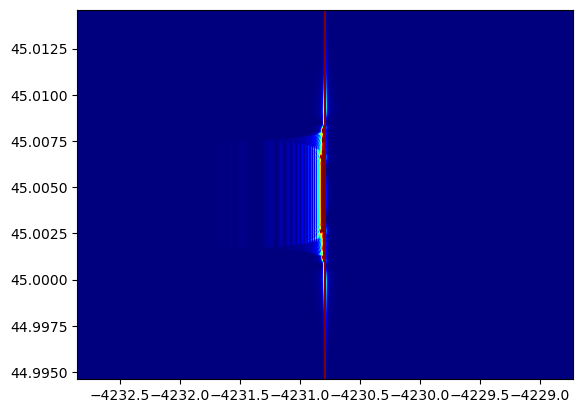

In [48]:
tic = time.time()
r00_theta_k = get_laue_transmission(kin_grid=kin_grid, 
                                     normal_grid=normal_grid,
                                     h_grid=h_grid,
                                     thickness=thickness,
                                     chi0=Diamond004['chi0'],
                                     chih=Diamond004['chih_sigma'],
                                     chihbar=Diamond004['chihbar_sigma'],)
r00_theta_t = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(r00_theta_k, axes=0), axis=0), axes=0)
toc = time.time()
print("It takes {:.2f} seconds to finish {} Energy calculation".format(toc - tic, theta_0))

plt.imshow(np.abs(np.square(np.abs(r00_theta_t.T))), 
           aspect='auto',
           cmap='jet',
           extent=[axis_info['time_grid'][0],axis_info['time_grid'][1],
                   np.rad2deg(angle_lim[0]), np.rad2deg(angle_lim[1]),],
           vmin=0,
           vmax=0.005,
          )
plt.show()